In [17]:
# --- Imports
import numpy as np
from random import random, seed
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Model imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


# --- Settings
np.random.seed(3)
sns.set_theme(style='whitegrid')

In [18]:
def FrankeFunction(x,y): # From excercise description
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [19]:
def plotting_test_values(X, z, z_pred, n, lmbd, degree):
    """Plots the data in 3D"""
    sort_idx = np.argsort(X[:,0])
    X_sorted = X[sort_idx]
    z_sorted = z[sort_idx]
    z_pred_sorted = z_pred[sort_idx]

    m = int(X.shape[0]/n)
    x = X_sorted[:,0].reshape((m, n))
    y = X_sorted[:,1].reshape((m, n))
    z = z_sorted.reshape((m, n))
    z_pred_plot = z_pred_sorted.reshape((m, n))

    fig = plt.figure(figsize=(12, 6))

    # Plotting the datapoints
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z)
    ax.set_title('Franke Function')

    # Plot the polynomial regression prediction (ideally a plane)
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(x, y, z_pred_plot)
    ax.set_title(rf'Lasso Prediction ($\lambda$ = {lmbd}, degree {degree})')

    plt.show()
    plt.close()

In [20]:
# Making data
n = 100
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
x, y = np.meshgrid(x,y)
# Unraveling to n^2-arrays
x = x.ravel()
y = y.ravel()

k = .01 # noise coefficient
z = FrankeFunction(x,y) + k*np.random.randn(n**2) # target variable with standard normal noise

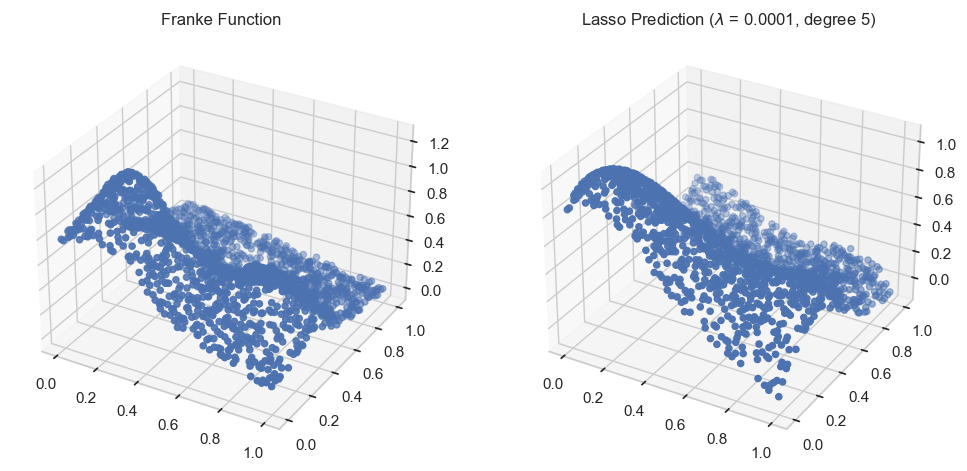

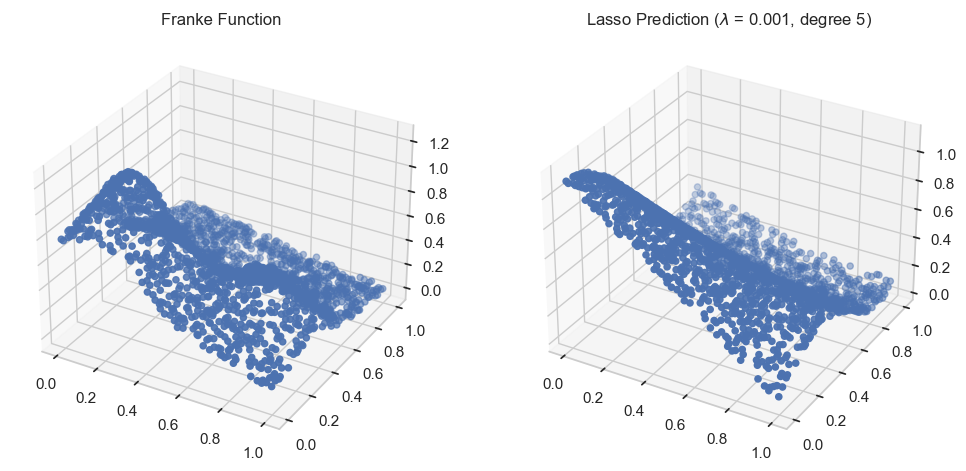

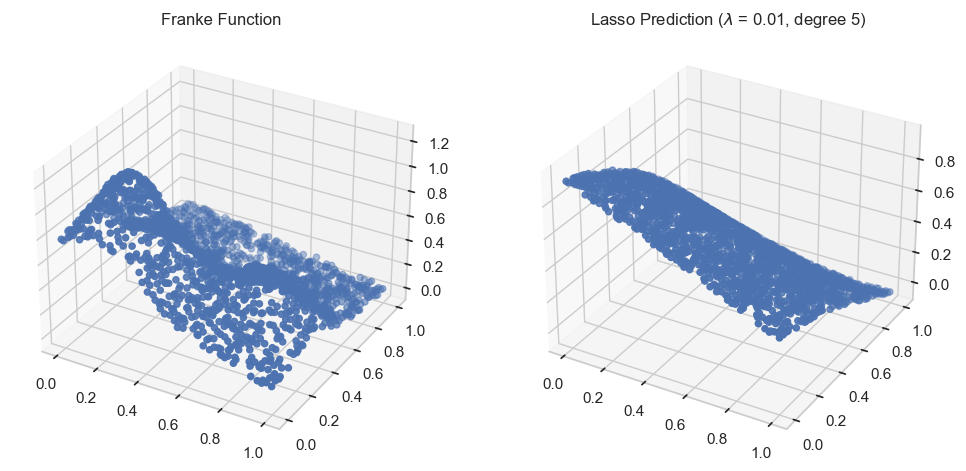

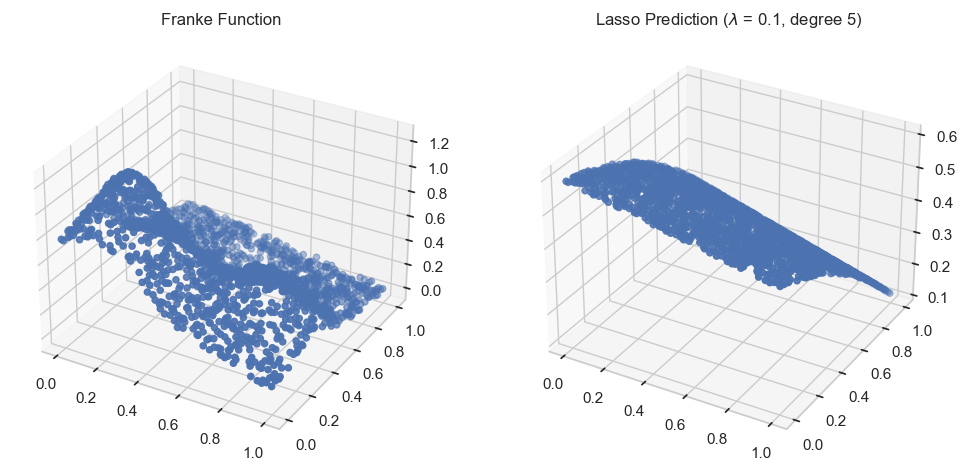

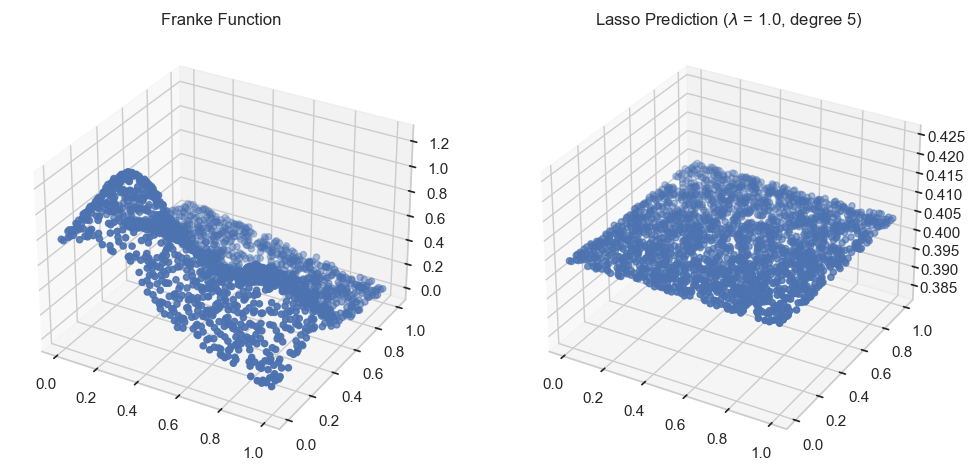

In [30]:
p = 5 # highest polynomial degree 
N = np.arange(p+1) # for looping and plotting later
L = [int((p+1)*(p+2)/2) for p in N] # beta lengths
l = L[-1] # greatest beta length

logmin, logmax, m = -4, 0, 5 # logspce start, end, number of lambda values
llambdas = np.logspace(logmin, logmax, m)

beta_values = np.zeros((p+1, l, m))
MSE_train, MSE_test = np.zeros((p+1, m)), np.zeros((p+1, m))
R2_train, R2_test = np.zeros((p+1, m)), np.zeros((p+1, m))

for i in N:
    # we stack the values of x and y beside each other
    X = np.column_stack((x,y))

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=3)

    for idx, lmbd in enumerate(llambdas):
        # we use pipeline to fit our model
        pipeline = make_pipeline(
            PolynomialFeatures(degree=i),
            StandardScaler(),
            Lasso(alpha=lmbd, max_iter=64_000))

        pipeline.fit(X_train,z_train)
        z_tilde = pipeline.predict(X_train)
        z_predict = pipeline.predict(X_test)

        MSE_train[i, idx] = mean_squared_error(z_train, z_tilde)
        MSE_test[i, idx] = mean_squared_error(z_test, z_predict)
        R2_train[i, idx] = r2_score(z_train, z_tilde)
        R2_test[i, idx] = r2_score(z_test, z_predict)

        coefs = pipeline.named_steps['lasso'].coef_

        beta_values[i,:len(coefs),idx] = coefs

        if i == N[-1]: 
            plotting_test_values(X_test, z_test, z_predict, 100, lmbd, i)

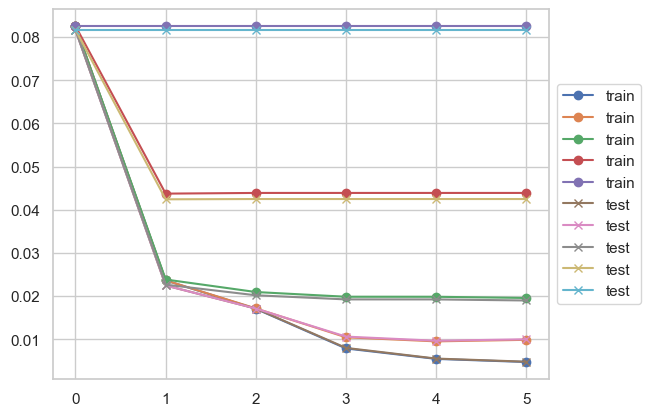

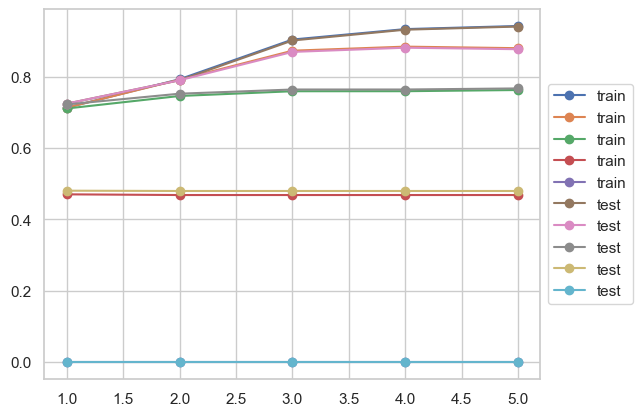

In [31]:
# Plotting MSE and R2 against complexity
plt.plot(N, MSE_train, 'o-', label='train')
plt.plot(N, MSE_test, 'x-', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

plt.plot(N[1:], R2_train[1:,:], 'o-', label='train')
plt.plot(N[1:], R2_test[1:,:], 'o-', label='test')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True)
plt.show()

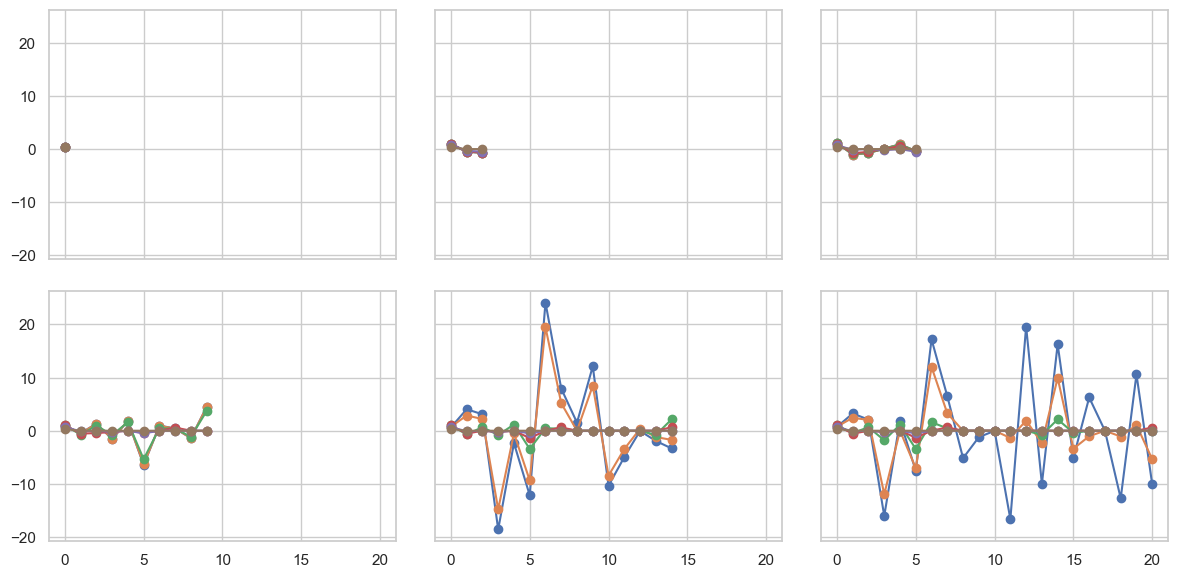

In [24]:
# Plotting all beta coefficients - could be prettier
fig, axs = plt.subplots(2,3, figsize=(12, 6), sharex=True, sharey=True); fig.tight_layout()
axs = axs.flatten()

for i,l in enumerate(L):
    axs[i].plot(np.arange(l), beta_values[i][:l], 'o-')
    # a legend in the first plot with the lambda-values would be nice...
plt.show()